# Processmento de dados

Tcc aaaala




# Anotações
-  normalizar as notas por periodo e depois juntar, e assim, evitar os agrupamentos
-  treinar modelos com diferentes períodos.

- remover outliers para cada categoria de conforto térmico (-3 a -3)

# Bibliotecas

In [8]:
# BIBLIOTECAS
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import  mean_squared_error, accuracy_score, f1_score, precision_score, recall_score, r2_score
import shap
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Funções

In [9]:
# FUNÇÕES ORGANIZADAS EM ORDEM ALFABÉTICA, COM DOCSTRING E COMENTÁRIOS DETALHADOS
def analyze_columns(dataframe, valores_permitidos=None, n_unicos=10):
    """
    Analisa um DataFrame e verifica conformidade com valores permitidos.
    Parâmetros:
        dataframe (pd.DataFrame): O DataFrame a ser analisado.
        valores_permitidos (dict): Dicionário com valores permitidos para colunas.
        n_unicos (int): Número máximo de valores únicos a serem exibidos.
    Retorna:
        pd.DataFrame: DataFrame com informações sobre cada coluna.
    """
    # Inicializa dicionário de valores permitidos, se não fornecido
    if valores_permitidos is None:
        valores_permitidos = {}
    analysis = []
    # Itera sobre todas as colunas do DataFrame
    for col in dataframe.columns:
        missing_count = dataframe[col].isnull().sum()  # Conta valores ausentes
        missing_percentage = (missing_count / len(dataframe)) * 100  # Percentual de ausentes
        if dataframe[col].dtype == 'object' or dataframe[col].nunique() < 50:
            # Variáveis categóricas ou com poucos valores únicos
            unique_values = dataframe[col].dropna().unique()
            valores_validos = True
            valores_n_validos = 'N/A'
            if col in valores_permitidos:
                valores_validos_col = valores_permitidos.get(col)
                if list(unique_values) not in valores_validos_col:
                    valores_validos = False
                valores_n_validos = list(set(unique_values) - set(valores_validos_col))
            analysis.append({
                'Coluna': col,
                'dtype': dataframe[col].dtype,
                'Tipo': 'Categórica',
                'Valores ausentes': missing_count,
                '% ausentes': round(missing_percentage, 2),
                'Valores únicos': unique_values[:n_unicos],  # Mostra os primeiros N valores únicos
                'Contagem únicos': len(unique_values),
                'Valores Válidos': valores_validos,
                'Valores Não Válidos': valores_n_validos
            })
        else:
            # Variáveis numéricas
            min_col = dataframe[col].min()
            max_col = dataframe[col].max()
            valores_validos = True
            valores_n_validos = 'N/A'
            if col in valores_permitidos:
                valores_validos_col = valores_permitidos.get(col)
                min_validos = min(valores_validos_col)
                max_validos = max(valores_validos_col)
                if min_col < min_validos:
                    valores_validos = False
                    valores_n_validos = f"< {min_validos}"
                elif max_col > max_validos:
                    valores_validos = False
                    valores_n_validos = f"> {max_validos}"
            analysis.append({
                'Coluna': col,
                'Tipo': 'Numérica',
                'Valores ausentes': missing_count,
                '% ausentes': round(missing_percentage, 2),
                'Min': min_col,
                'Max': max_col,
                'Médio': dataframe[col].mean(),
                'Contagem únicos': dataframe[col].nunique(),
                'Valores Válidos': valores_validos,
                'Valores Não Válidos': valores_n_validos
            })
    return pd.DataFrame(analysis)

def apply_column_types(df, type_dict):
    """
    Aplica tipos de dados a um DataFrame com base em um dicionário, usando pd.to_numeric para tipos numéricos.
    Parâmetros:
        df (pd.DataFrame): O DataFrame a ser processado.
        type_dict (dict): Dicionário mapeando colunas para tipos desejados.
    Retorna:
        pd.DataFrame: DataFrame com tipos atualizados.
    """
    for col, dtype in type_dict.items():
        if col in df.columns:
            try:
                if dtype == 'datetime64[ns]':
                    # Converte para datetime, erros viram NaT
                    df[col] = pd.to_datetime(df[col], errors='coerce')
                elif dtype == 'float64' or dtype == 'np.Int64':
                    # Converte para numérico, erros viram NaN
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                    if dtype == 'Int64':
                        df[col] = df[col].astype('Int64')
                else:
                    # Conversão geral
                    df[col] = df[col].astype(dtype)
            except Exception as e:
                print(f"Erro ao converter coluna {col} para {dtype}: {e}")
        else:
            print(f"Coluna {col} não encontrada no DataFrame.")
    return df

def balancear_smote_tomek(X, y):
    """
    Aplica o balanceamento SMOTETomek para tratar desbalanceamento de classes.
    Parâmetros:
        X (pd.DataFrame): Features.
        y (pd.Series): Target.
    Retorna:
        X_res, y_res: Features e target balanceados.
    """
    smt = SMOTETomek(random_state=42)  # Instancia o balanceador
    X_res, y_res = smt.fit_resample(X, y)  # Aplica o balanceamento
    return X_res, y_res

def calcular_absolute_humidity(temperatura, umidade):
    """
    Calcula a umidade absoluta a partir da temperatura e umidade relativa.
    Parâmetros:
        temperatura (float): Temperatura do ar em °C.
        umidade (float): Umidade relativa do ar em %.
    Retorna:
        float: Umidade absoluta.
    """
    vapor_pressure = calcular_vapor_pressure(temperatura, umidade)  # Calcula pressão de vapor
    R = 8.314  # Constante dos gases ideais (J/mol K)
    return (vapor_pressure * 1000) / (R * (temperatura + 273.15))

def calcular_dew_point(temperatura, umidade):
    """
    Calcula o ponto de orvalho a partir da temperatura e umidade relativa.
    Parâmetros:
        temperatura (float): Temperatura do ar em °C.
        umidade (float): Umidade relativa do ar em %.
    Retorna:
        float: Ponto de orvalho.
    """
    return temperatura - ((100 - umidade) / 5)

def calcular_heat_index(temperatura, umidade):
    """
    Calcula o índice de calor a partir da temperatura e umidade relativa.
    Parâmetros:
        temperatura (float): Temperatura do ar em °C.
        umidade (float): Umidade relativa do ar em %.
    Retorna:
        float: Índice de calor.
    """
    return -8.78469475556 + 1.61139411 * temperatura + 2.33854883889 * umidade - 0.14611605 * temperatura * umidade

def calcular_metricas(modelo, X_test, y_test, is_classification):
    """
    Calcula métricas de desempenho do modelo.
    Parâmetros:
        modelo: Modelo treinado.
        X_test: Features de teste.
        y_test: Target de teste.
        is_classification: True se classificação, False se regressão.
    Retorna:
        pd.DataFrame: DataFrame com as métricas.
    """
    y_pred = modelo.predict(X_test)
    if is_classification:
        metrics = {
            "Acurácia": accuracy_score(y_test, y_pred),
            "F1-score": f1_score(y_test, y_pred, average="weighted"),
            "Precisão": precision_score(y_test, y_pred, average="weighted"),
            "Revocação": recall_score(y_test, y_pred, average="weighted")
        }
    else:
        metrics = {
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "R² Score": r2_score(y_test, y_pred)
        }
    return pd.DataFrame(metrics, index=[0])

def calcular_tmb(sexo_masculino, peso, altura, idade):
    """
    Calcula a Taxa Metabólica Basal (TMB) usando Harris-Benedict.
    Parâmetros:
        sexo_masculino (int): 1 para masculino, 0 para feminino.
        peso (float): Peso em kg.
        altura (float): Altura em cm.
        idade (int): Idade em anos.
    Retorna:
        float: TMB em kcal/dia.
    """
    if sexo_masculino == 1:
        tmb = 88.362 + (13.397 * peso) + (4.799 * altura) - (5.677 * idade)
    elif sexo_masculino == 0:
        tmb = 447.593 + (9.247 * peso) + (3.098 * altura) - (4.330 * idade)
    else:
        raise ValueError("Sexo inválido. Use 'M' ou 'F'.")
    return round(tmb, 2)

def calcular_tu_stull(temperatura, umidade_relativa):
    """
    Calcula a temperatura de bulbo úmido (Tu) usando a equação de Stull (2011).
    Parâmetros:
        temperatura (float): Temperatura do ar em °C (bulbo seco).
        umidade_relativa (float): Umidade relativa do ar em %.
    Retorna:
        float: Temperatura de bulbo úmido (Tu) em °C.
    """
    tu = (
        temperatura * np.arctan(0.151977 * np.sqrt(umidade_relativa + 8.313659))
        + np.arctan(temperatura + umidade_relativa)
        - np.arctan(umidade_relativa - 1.676331)
        + 0.00391838 * (umidade_relativa ** 1.5) * np.arctan(0.023101 * umidade_relativa)
        - 4.686035
    )
    return tu

def calcular_vapor_pressure(temperatura, umidade):
    """
    Calcula a pressão de vapor a partir da temperatura e umidade relativa.
    Parâmetros:
        temperatura (float): Temperatura do ar em °C.
        umidade (float): Umidade relativa do ar em %.
    Retorna:
        float: Pressão de vapor.
    """
    return umidade * 6.112 * np.exp((17.67 * temperatura) / (temperatura + 243.5))

def classificar_imc(imc):
    """
    Retorna a categoria do IMC de acordo com os intervalos da tabela fornecida.
    Parâmetros:
        imc (float): Valor do IMC.
    Retorna:
        str: Categoria do IMC.
    """
    if imc < 20:
        return 'Abaixo do peso'
    elif 20 <= imc < 25:
        return 'Peso Normal'
    elif 25 <= imc < 30:
        return 'Excesso de peso'
    elif 30 <= imc <= 35:
        return 'Obesidade'
    else:
        return 'Super Obesidade'

def dicionarioColunasNormalizadas(df):
    """
    Gera um dicionário para normalizar nomes de colunas (minúsculas).
    Parâmetros:
        df (pd.DataFrame): DataFrame de entrada.
    Retorna:
        dict: Dicionário de nomes normalizados.
    """
    cabecalhos = dict(zip(list(df.columns), [str(nome).lower() for nome in list(df.columns)]))
    return cabecalhos

def gerar_pairplot(df, features, hue_col="mes-ano", fonte_size=10):
    """
    Gera um pairplot com configurações personalizadas.
    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os dados.
        features (list): Lista de colunas numéricas a serem plotadas.
        hue_col (str): Coluna para definir a cor dos pontos (default: "mes-ano").
        fonte_size (int): Tamanho da fonte dos eixos e legenda (default: 10).
    Retorna:
        None. Exibe um gráfico PairPlot personalizado.
    """
    numericas = df[features + [hue_col]]  # Seleciona colunas necessárias
    g = sns.pairplot(numericas, hue=hue_col, diag_kind="hist")  # Cria o PairPlot
    for ax in g.axes.flatten():  # Personaliza rótulos dos eixos
        if ax is not None:
            ax.set_xlabel(ax.get_xlabel(), fontsize=fonte_size)
            ax.set_ylabel(ax.get_ylabel(), fontsize=fonte_size)
            ax.tick_params(axis='both', which='major', labelsize=fonte_size, labelcolor='black')
    legend = g._legend
    legend.set_title(hue_col, prop={'size': fonte_size})
    for text in legend.get_texts():
        text.set_fontsize(fonte_size)
    legend.get_frame().set_edgecolor("black")
    legend.get_frame().set_linewidth(1.2)
    plt.suptitle("", fontsize=fonte_size * 1.5, weight='bold', y=1.02)
    plt.show()

def inferir_e_corrigir(df, tipo):
    """
    Infere se a maioria dos elementos de uma coluna são de um tipo específico e substitui inválidos pela média.
    Parâmetros:
        df (pd.DataFrame): DataFrame de entrada.
        tipo (type): Tipo desejado (ex: int, float).
    Retorna:
        pd.DataFrame: DataFrame ajustado.
    """
    for coluna in df.columns:
        try:
            valores_convertidos = pd.to_numeric(df[coluna], errors='coerce')  # Converte valores
            num_validos = valores_convertidos.notna().sum()  # Conta válidos
            if num_validos > len(df[coluna]) / 2:
                media_valores = valores_convertidos.mean()  # Média dos válidos
                df[coluna] = valores_convertidos.fillna(media_valores).astype(tipo)
        except Exception as e:
            print(f"Erro ao processar a coluna '{coluna}': {e}")
    return df

def labelEncoder_com_dicionario(series):
    """
    Codifica uma série usando LabelEncoder e retorna valores codificados e dicionário de decodificação.
    Parâmetros:
        series (pd.Series): Série do pandas a ser codificada.
    Retorna:
        tuple: (valores_codificados, dicionario_decodificacao)
    """
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()  # Instancia o encoder
    valores_codificados = encoder.fit_transform(series)  # Codifica
    dicionario_decodificacao = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))  # Dicionário
    return valores_codificados, dicionario_decodificacao

def plot_discrete_histogram(data, column, title="Histograma", xlabel="Valores", ylabel="Frequência", bins=7, color="blue", edgecolor="black", fontsize=12, grid=True):
    """
    Gera um histograma para valores discretos no intervalo de -3 a 3 com opções de personalização.
    Parâmetros:
        data (pd.DataFrame): Dados.
        column (str): Nome da coluna.
        title (str): Título do gráfico.
        xlabel (str): Rótulo do eixo X.
        ylabel (str): Rótulo do eixo Y.
        bins (int): Número de bins.
        color (str): Cor das barras.
        edgecolor (str): Cor da borda.
        fontsize (int): Tamanho da fonte.
        grid (bool): Ativa grade.
    Retorna:
        None. Exibe o histograma.
    """
    plt.figure(figsize=(8, 5))  # Define tamanho
    sns.histplot(data[column], bins=bins, discrete=True, color=color, edgecolor=edgecolor)  # Plota
    plt.title(title, fontsize=fontsize, weight="bold")
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xticks(range(-3, 4), fontsize=fontsize - 2, weight="bold")
    plt.yticks(fontsize=fontsize - 2, weight="bold")
    if grid:
        plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

def preprocessar_dados(df, target, features):
    """
    Normaliza os dados e separa treino e teste.
    Parâmetros:
        df (pd.DataFrame): DataFrame com os dados.
        target (str): Nome da variável resposta.
        features (list): Lista das colunas de features.
    Retorna:
        X_train, X_test, y_train, y_test: Dados divididos para treino e teste.
    """
    df = df.copy()  # Evita alterar o original
    if df[target].dtype == "object":
        df[target] = LabelEncoder().fit_transform(df[target])  # Codifica target se categórico
    X = df[features]  # Seleciona features
    y = df[target]    # Seleciona target
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y )  # Split
    return X_train, X_test, y_train, y_test

def treinar_random_forest(X_train, y_train):
    """
    Treina um modelo Random Forest (classificação ou regressão).
    Parâmetros:
        X_train: Features de treino.
        y_train: Target de treino.
    Retorna:
        modelo: Modelo treinado.
        is_classification: True se classificação, False se regressão.
    """
    num_classes = len(np.unique(y_train))
    is_classification = num_classes <= 10
    if is_classification:
        modelo = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        print("Modelo de Classificação")
    else:
        modelo = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        print("Modelo de Regressão")
    modelo.fit(X_train, y_train)
    return modelo, is_classification

In [10]:
# DICIONÁRIOS E LISTAS UTILIZADOS NO PROCESSAMENTO DOS DADOS

# Dicionário de valores permitidos para validação de colunas específicas
valores_permitidos = {
    '6': [-3, -2, -1, 0, 1, 2, 3],  # Valores válidos para a coluna '6' (ex: escala Likert)
    'peso': [10, 131],              # Faixa de valores válidos para peso (kg)
    'altura': [100, 200]            # Faixa de valores válidos para altura (cm)
}

# Dicionário de substituições para padronizar valores
substituicoes = {
    99: 0,     # Substitui 99 por 0 (ex: valores faltantes ou codificação antiga)
    'x': 0,   # Substitui 'x' por 0
    'F': 'f'  # Padroniza 'F' para 'f' (ex: sexo)
}

# Dicionário que define o tipo de cada coluna do DataFrame
# Usado para garantir que cada coluna tenha o tipo correto durante o processamento
# 'datetime64[ns]' para datas e horários, 'Int64' para inteiros com suporte a NaN, 'float64' para números reais, 'string' para texto/categóricos
# Comentários ao lado explicam o significado de cada coluna

type_dict = {
    'data': 'datetime64[ns]',     # Datas das medições
    'hora': 'datetime64[ns]',     # Horários das medições
    'idade': 'Int64',             # Idades dos entrevistados (inteiro, pode ter NaN)
    'sexo': 'string',             # Sexo do entrevistado (categórico)
    'peso': 'Int64',              # Peso do entrevistado (kg)
    'altura': 'float64',          # Altura do entrevistado (cm)
    'vestimenta': 'string',       # Tipo de vestimenta (categórico)
    'p1': 'Int64',                # Pergunta 1 (resposta numérica inteira)
    'p2': 'Int64',                # Pergunta 2
    'p3': 'Int64',                # Pergunta 3
    'p4': 'Int64',                # Pergunta 4
    'p5': 'Int64',                # Pergunta 5
    'p6': 'Int64',                # Pergunta 6
    'p7': 'Int64',                # Pergunta 7
    'p8': 'Int64',                # Pergunta 8
    'tev': 'float64',             # Temperatura efetiva do vento
    'utci': 'float64',            # Índice UTCI
    'sst': 'float64',             # Temperatura superficial do solo
    'ste': 'float64',             # Temperatura superficial externa
    'psti': 'float64',            # Índice PSTI
    'wbgt': 'float64',            # Índice WBGT
    'wci': 'float64',             # Índice WCI
    'tek': 'float64',             # Temperatura efetiva do corpo
    'te': 'float64',              # Temperatura efetiva
    'pst': 'float64',             # Pressão de saturação
    'tmedia': 'float64',          # Temperatura média do ar
    'tmax': 'float64',            # Temperatura máxima
    'tmin': 'float64',            # Temperatura mínima
    'tu': 'float64',              # Temperatura de bulbo úmido
    'ur': 'float64',              # Umidade relativa do ar
    'ur_max': 'float64',          # Umidade relativa máxima
    'ur_min': 'float64',          # Umidade relativa mínima
    'rsolarmed': 'float64',       # Radiação solar média
    'rsolartot': 'float64',       # Radiação solar total
    'vel_vento': 'float64',       # Velocidade do vento
    'dir_vento': 'float64',       # Direção do vento
    'sd_dirvento': 'float64',     # Desvio padrão da direção do vento
    'vel_vento_max': 'float64',   # Velocidade máxima do vento
    'dir_max_vento': 'float64',   # Direção máxima do vento
    'chuva_tot': 'float64'        # Total de chuva
}

trocar_valores = {
    'x': np.nan,   # Substitui 'x' por NaN
    '99': np.nan  # Substitui '99' por NaN
}

# Seleção das variáveis de interesse para análise e modelagem
features_tempo = ['data', 'hora']  # Variáveis temporais
features_categoricas = ['sexo']    # Variáveis categóricas
features_numericas = [             # Variáveis numéricas principais
    'idade', 'peso', 'altura', 'vestimenta',
    'tmedia', 'tmax', 'tmin', 'tu', 'ur', 'ur_max', 'ur_min',
    'rsolarmed', 'rsolartot', 'vel_vento', 'dir_vento',
    'sd_dirvento', 'vel_vento_max', 'dir_max_vento',
    'chuva_tot'
]
features_numericas_ = [            # Subconjunto de variáveis numéricas
    'idade', 'peso', 'altura', 'vestimenta',
    'tmedia', 'rsolarmed', 'vel_vento_max',
    'chuva_tot'
]
features_perguntas = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']  # Perguntas do questionário
features_climatologicas_relevantes = [  # Variáveis climáticas para análise
    'tmedia', 'tu', 'ur', 'rsolarmed', 'vel_vento', 'chuva_tot'
]
features_entrevistados = ['idade', 'peso', 'altura', 'vestimenta', 'sexo']  # Variáveis dos entrevistados
todas = features_categoricas + features_numericas + features_tempo + features_perguntas  # Todas as variáveis relevantes


# Carregamento

In [11]:
# Carregamento dos dados brutos do Excel e normalização dos nomes das colunas
df_bruto = pd.read_excel('dados/dado_brutos.xlsx')  # Lê o arquivo Excel com os dados brutos
df_bruto = df_bruto.rename(columns=dicionarioColunasNormalizadas(df_bruto))  # Normaliza os nomes das colunas para minúsculas

# Pré-análise

In [12]:
# Pré-análise: análise exploratória inicial das colunas do DataFrame bruto
df_analise = analyze_columns(df_bruto)  # Executa análise das colunas, tipos, valores ausentes e únicos
df_analise  # Exibe o DataFrame de análise para inspeção

,Coluna,dtype,Tipo,Valores ausentes,% ausentes,Valores únicos,Contagem únicos,Valores Válidos,Valores Não Válidos,Min,Max,Médio
0,data,datetime64[ns],Categórica,0,0.00,"[2015-08-05 00:00:00, 2015-08-06 00:00:00, 201...",9,True,N/A,NaN,NaN,NaN
1,hora,object,Categórica,0,0.00,"[09:10:00, 09:20:00, 09:30:00, 09:40:00, 09:50...",48,True,N/A,NaN,NaN,NaN
2,idade,int64,Categórica,0,0.00,"[51, 50, 25, 27, 35, 30, 26, 22, 23, 33]",44,True,N/A,NaN,NaN,NaN
3,sexo,object,Categórica,0,0.00,"[f, m, F]",3,True,N/A,NaN,NaN,NaN
4,peso,NaN,Numérica,0,0.00,NaN,76,True,N/A,26.00,130.00,70.675581
5,altura,int64,Categórica,0,0.00,"[163, 170, 185, 160, 167, 190, 173, 174, 155, ...",49,True,N/A,NaN,NaN,NaN
6,vestimenta,float64,Categórica,3,0.17,"[0.5, 1.0, 9.5, 0.4, 2.0, -1.0, 0.0]",7,True,N/A,NaN,NaN,NaN
7,p1,int64,Categórica,0,0.00,"[0, -1, 1, 2, -2, 3, -3]",7,True,N/A,NaN,NaN,NaN
8,p2,int64,Categórica,0,0.00,"[0, 1, 3, 2, -3, -1]",6,True,N/A,NaN,NaN,NaN
9,p3,int64,Categórica,0,0.00,"[0, -2, 2, 1, -1, -3, 3]",7,True,N/A,NaN,NaN,NaN


In [16]:
# IMPUTAÇÃO DE VALORES AUSENTES
df = df_bruto.copy()  # Cria uma cópia do DataFrame bruto para evitar alterações no original
# Isso garante que o pandas reconheça corretamente os valores faltantes
df['mes-ano'] = df.data.dt.month.astype(str)+" - "+ df.data.dt.year.astype(str)


df = df.replace(substituicoes)

df['data_cplt'] = pd.to_datetime(df['data'].astype('str')+ ' ' +df['hora'].astype('str'))
# Substitui o texto 'NAN' por np.nan para padronizar valores ausentes

df = df.replace('NAN', np.nan)

# Conta o número de linhas com pelo menos um valor ausente (antes da imputação)
passo_1 = df.isna().any(axis=1).sum()
print('Verificando número de valores ausentes após imputação "passo 1: ' + str(passo_1))

# Preenche valores ausentes na coluna 'p5' usando o valor seguinte disponível (backfill)
df['p5'] = df['p5'].bfill()
passo_2 = df.isna().any(axis=1).sum()
print('Verificando número de valores ausentes após imputação "passo 2: ' + str(passo_2))

# Preenche valores ausentes na coluna 'p6' usando o valor seguinte disponível (backfill)
df['p6'] = df['p6'].bfill()
passo_3 = df.isna().any(axis=1).sum()
print('Verificando número de valores ausentes após imputação "passo 3: ' + str(passo_3))

# Preenche valores ausentes na coluna 'p7' usando o valor seguinte disponível (backfill)
df['p7'] = df['p7'].bfill()
passo_4 = df.isna().any(axis=1).sum()
print('Verificando número de valores ausentes após imputação "passo 4: ' + str(passo_4))

# Preenche valores ausentes na coluna 'p8' usando o valor seguinte disponível (backfill)
df['p8'] = df['p8'].bfill()
passo_5 = df.isna().any(axis=1).sum()
print('Verificando número de valores ausentes após imputação "passo 5: ' + str(passo_5))

# Preenche valores ausentes na coluna 'vestimenta' usando o valor seguinte disponível (backfill)
df['vestimenta'] = df['vestimenta'].bfill()
passo_6 = df.isna().any(axis=1).sum()
print('Verificando número de valores ausentes após imputação "passo 6: ' + str(passo_6))

# Preenche valores ausentes em 'tu' calculando o valor com a função calcular_tu_stull
# Só aplica o cálculo se o valor estiver ausente
# Usa tmedia e ur como entrada para o cálculo
df['tu'] = df.apply(lambda row: calcular_tu_stull(row["tmedia"], row["ur"]) if pd.isna(row['tu']) else row['tu'], axis=1)
passo_7 = df.isna().any(axis=1).sum()
print('Verificando número de valores ausentes após imputação "passo 7: ' + str(passo_7))

# Preenche valores ausentes em 'rsolartot' usando a média móvel (rolling mean) e interpolação linear
# Primeiro, preenche com a média móvel de 48 períodos (ex: 2 dias se dados horários)
df['rsolartot'] = df['rsolartot'].fillna(df['rsolartot'].rolling(window=48, min_periods=1).mean())
# Depois, interpola valores restantes de forma linear
df['rsolartot'] = df['rsolartot'].interpolate(method='linear')
passo_8 = df.isna().any(axis=1).sum()
print('Verificando número de valores ausentes após imputação "passo 8: ' + str(passo_8))

# Preenche valores ausentes em 'rsolarmed' usando a média móvel e interpolação linear
# Mesmo procedimento de 'rsolartot'
df['rsolarmed'] = df['rsolarmed'].fillna(df['rsolarmed'].rolling(window=48, min_periods=1).mean())
df['rsolarmed'] = df['rsolarmed'].interpolate(method='linear')
passo_9 = df.isna().any(axis=1).sum()
print('Verificando número de valores ausentes após imputação "passo 9: ' + str(passo_9))


Verificando número de valores ausentes após imputação "passo 1: 435
Verificando número de valores ausentes após imputação "passo 2: 435
Verificando número de valores ausentes após imputação "passo 3: 435
Verificando número de valores ausentes após imputação "passo 4: 435
Verificando número de valores ausentes após imputação "passo 5: 434
Verificando número de valores ausentes após imputação "passo 6: 431
Verificando número de valores ausentes após imputação "passo 7: 216
Verificando número de valores ausentes após imputação "passo 8: 216
Verificando número de valores ausentes após imputação "passo 9: 0


In [17]:
# Análise das colunas após tratamento de tipos e valores
analyze_columns(apply_column_types(df, type_dict))  # Aplica tipos definidos e analisa novamente as colunas

,Coluna,dtype,Tipo,Valores ausentes,% ausentes,Valores únicos,Contagem únicos,Valores Válidos,Valores Não Válidos,Min,Max,Médio
0,data,datetime64[ns],Categórica,0,0.0,"[2015-08-05 00:00:00, 2015-08-06 00:00:00, 201...",9,True,N/A,NaN,NaN,NaN
1,hora,datetime64[ns],Categórica,1720,100.0,[],0,True,N/A,NaN,NaN,NaN
2,idade,Int64,Categórica,0,0.0,"[51, 50, 25, 27, 35, 30, 26, 22, 23, 33]",44,True,N/A,NaN,NaN,NaN
3,sexo,string[python],Categórica,0,0.0,"[f, m]",2,True,N/A,NaN,NaN,NaN
4,peso,NaN,Numérica,0,0.0,NaN,76,True,N/A,0,130,70.560465
5,altura,int64,Categórica,0,0.0,"[163, 170, 185, 160, 167, 190, 173, 174, 155, ...",49,True,N/A,NaN,NaN,NaN
6,vestimenta,string[python],Categórica,0,0.0,"[0.5, 1.0, 9.5, 0.4, 2.0, -1.0, 0.0]",7,True,N/A,NaN,NaN,NaN
7,p1,Int64,Categórica,0,0.0,"[0, -1, 1, 2, -2, 3, -3]",7,True,N/A,NaN,NaN,NaN
8,p2,Int64,Categórica,0,0.0,"[0, 1, 3, 2, -3, -1]",6,True,N/A,NaN,NaN,NaN
9,p3,Int64,Categórica,0,0.0,"[0, -2, 2, 1, -1, -3, 3]",7,True,N/A,NaN,NaN,NaN


# Análise Exploratória de dados

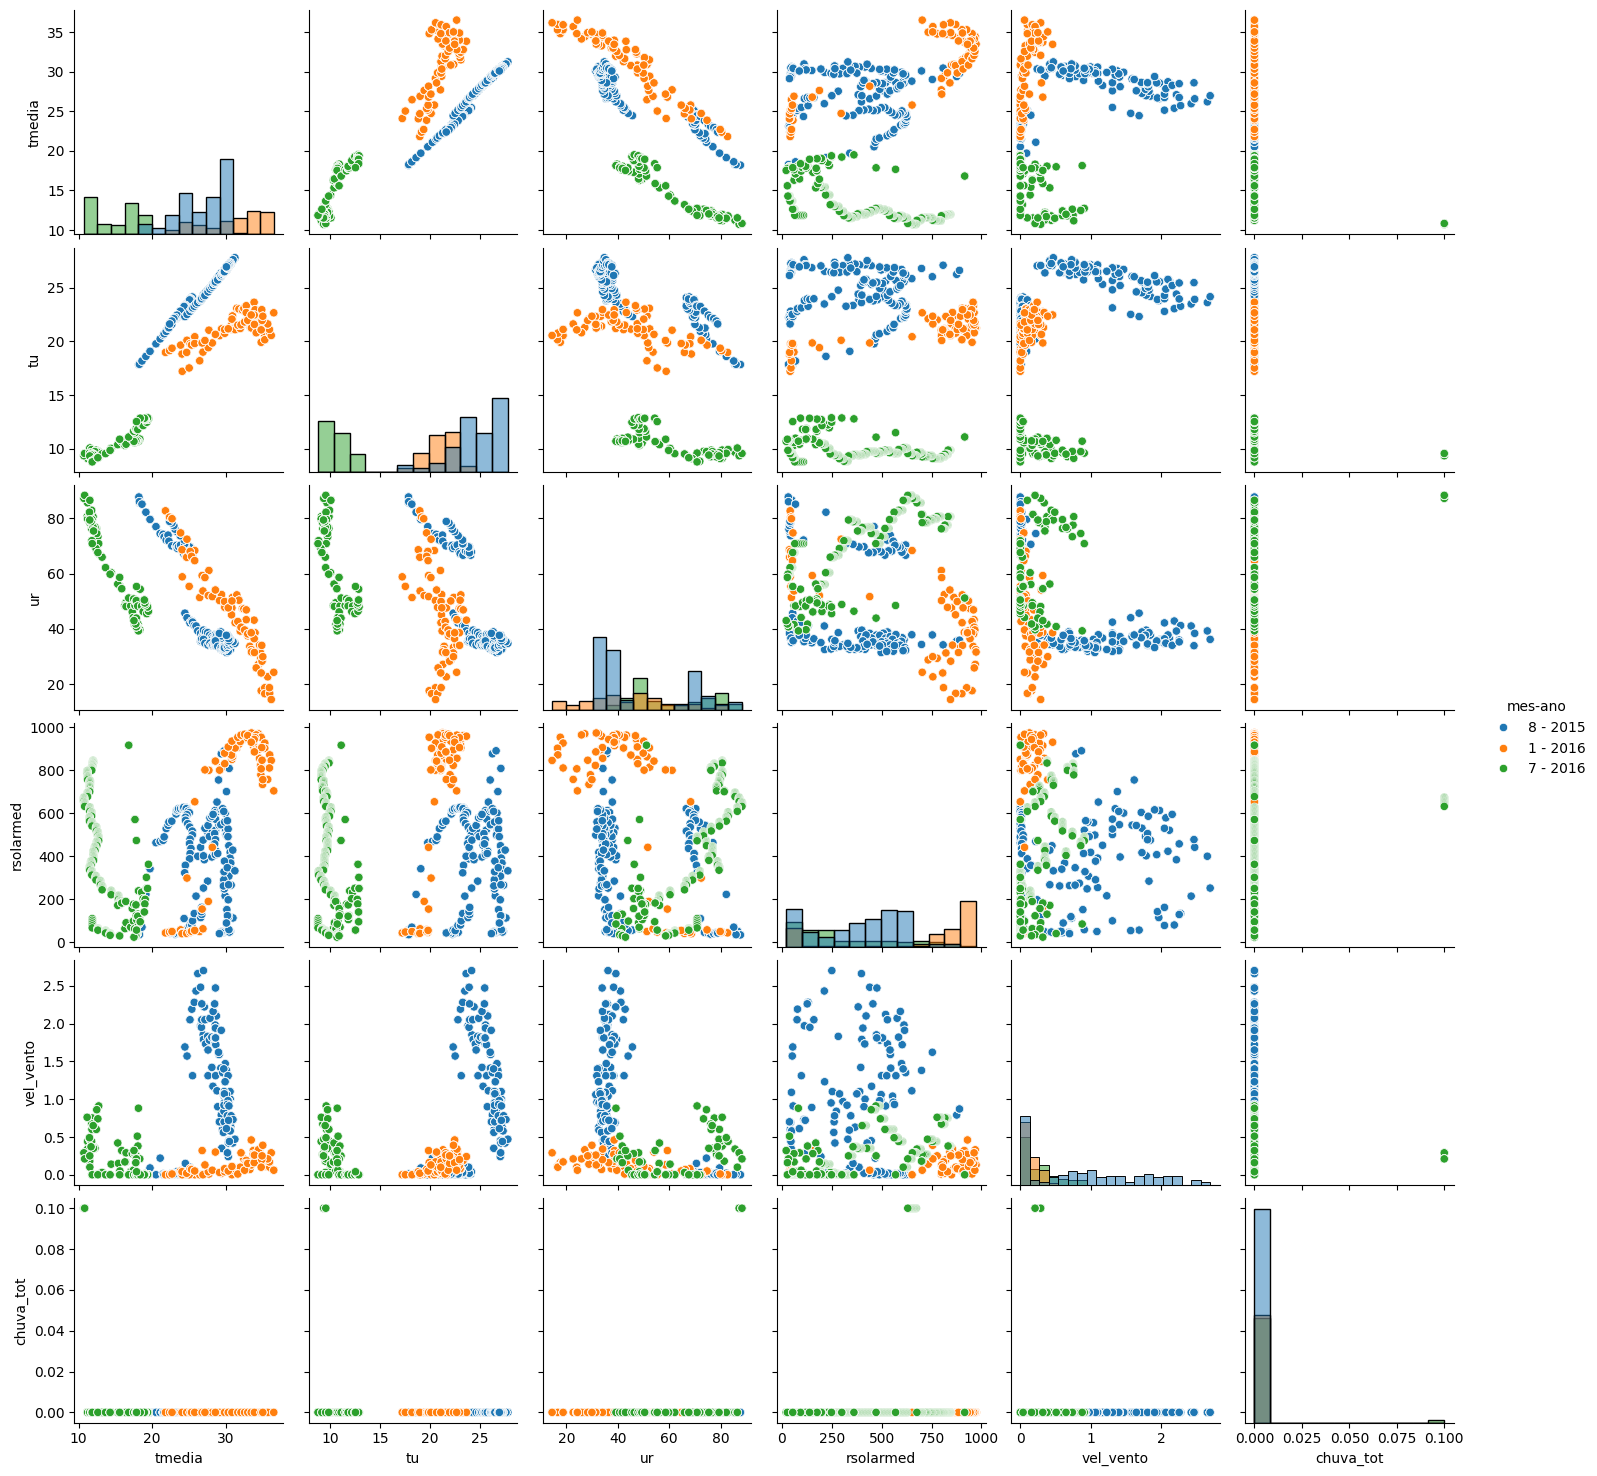

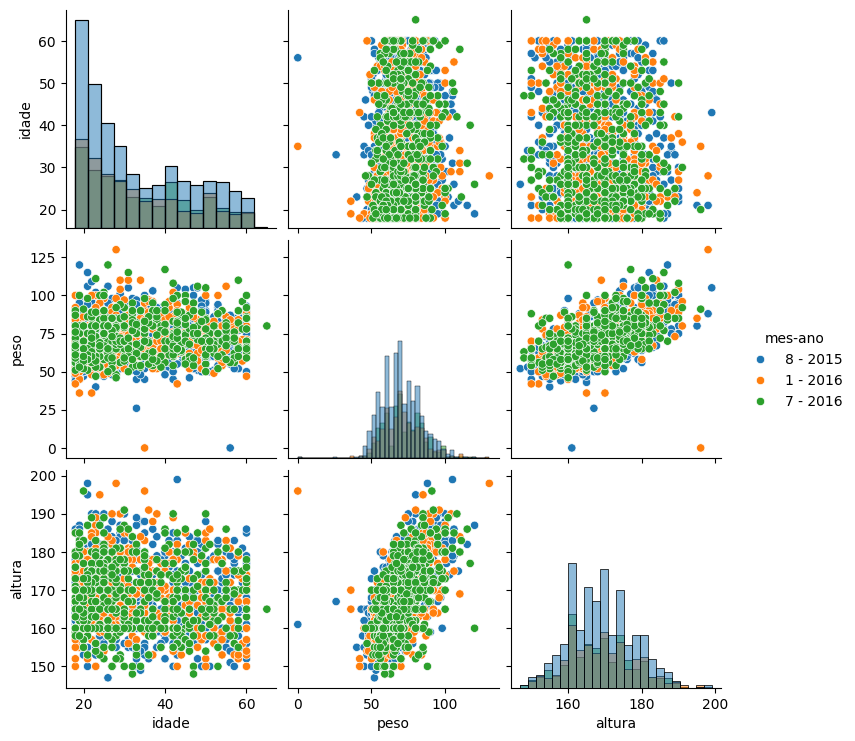

In [18]:
# Análise exploratória: visualização de relações entre variáveis
gerar_pairplot(df, features_climatologicas_relevantes)  # Pairplot para variáveis climáticas relevantes
gerar_pairplot(df, features_entrevistados)  # Pairplot para variáveis dos entrevistados

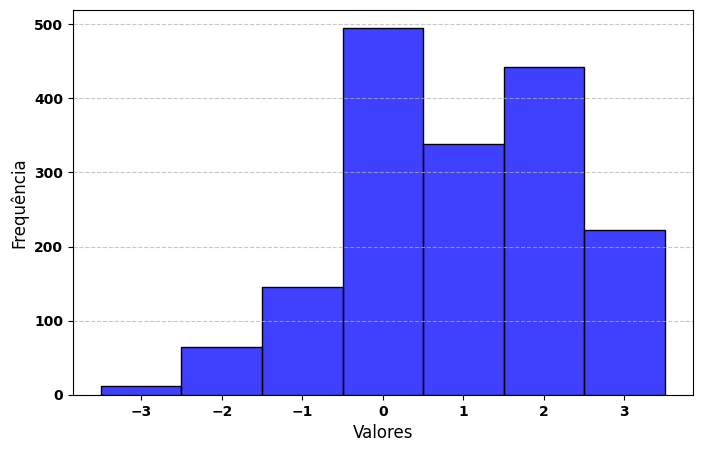

In [19]:
# Exemplo de uso do histograma discreto para a variável 'p1'
plot_discrete_histogram(df, 'p1', '')  # Gera histograma para a coluna 'p1'

# 2.Tranformação de variáveis ou Feature Engineer



In [21]:
# Feature Engineering: criação de novas variáveis

# Calcula o IMC (Índice de Massa Corporal) e cria uma nova coluna no DataFrame
# Fórmula: peso (kg) / altura (m)^2
# Altura está em cm, por isso divide por 100 antes de elevar ao quadrado
# Exemplo: 70kg, 170cm -> 70 / (1.7^2)
df['IMC'] = df['peso'] / ((df['altura']/100) ** 2)

# Classifica o IMC em categorias (abaixo do peso, normal, etc.) usando a função classificar_imc
df['IMC_classe'] = df['IMC'].apply(classificar_imc)

# Codifica a coluna 'mes-ano' em valores numéricos únicos
# Útil para modelos que não aceitam strings

# Cria novas colunas com índices e medidas climáticas
# Cada linha aplica a função correspondente usando valores das colunas
# Exemplo: calcula o índice de calor para cada linha
df['heat_index'] = df.apply(lambda row: calcular_heat_index(row['tmedia'], row['ur']), axis=1)
df['dew_point'] = df.apply(lambda row: calcular_dew_point(row['tmedia'], row['ur']), axis=1)
df['vapor_pressure'] = df.apply(lambda row: calcular_vapor_pressure(row['tmedia'], row['ur']), axis=1)
df['absolute_humidity'] = df.apply(lambda row: calcular_absolute_humidity(row['tmedia'], row['ur']), axis=1)

# Cria variáveis combinando temperatura e umidade de diferentes formas
df['t*u'] = df.apply(lambda row: row['tmedia']* row['ur'], axis=1)
df['t/u'] = df.apply(lambda row: row['tmedia']/ row['ur'], axis=1)
df['log(t)*u'] = df.apply(lambda row: np.log(row['tmedia'])* row['ur'], axis=1)
df['log(t*u)'] = df.apply(lambda row: np.log(row['tmedia']* row['ur']), axis=1)
df['log(t/u)'] = df.apply(lambda row: np.log(row['tmedia']/ row['ur']), axis=1)

# Codifica variáveis categóricas em números e salva dicionários de decodificação
# Útil para reverter a codificação depois, se necessário
df['mes-ano_encod'], dict_decode_mes_ano = labelEncoder_com_dicionario(df['mes-ano'])
df['imc_classe_encod'], dict_decode_imc = labelEncoder_com_dicionario(df['IMC_classe'])
df['sexo_encod'], dict_decode_sexo = labelEncoder_com_dicionario(df['sexo'])
df['hora_encod'], dict_decode_p1 = labelEncoder_com_dicionario(df['hora'])
df['p1_encod'], dict_decode_p1 = labelEncoder_com_dicionario(df['p1'])

# Calcula a taxa metabólica basal para cada linha usando a função calcular_tmb
df['taxa_metabolica_basal'] = df.apply(lambda row: calcular_tmb(row['sexo_encod'], row['peso'], row['altura'], row['idade']), axis=1)

# Lista com os nomes das novas features numéricas criadas
novas_features_numericas = ['IMC', 'heat_index', 'dew_point', 'vapor_pressure', 'absolute_humidity', 't*u', 't/u', 'log(t)*u', 'log(t*u)', 'log(t/u)']


In [22]:
# Normalização das variáveis numéricas e das novas features, separadamente para cada grupo de 'mes-ano'
scaler = StandardScaler()  # Instancia o normalizador padrão
lista_grupos = df['mes-ano'].unique()  # Lista de todos os grupos de mês-ano
lista_var_normalizar = features_numericas + novas_features_numericas  # Variáveis a normalizar
lista_nomes_colunas_norm = [f"{x}_norm" for x in lista_var_normalizar]  # Nomes das colunas normalizadas
for group in lista_grupos:
    mask = df['mes-ano'] == group  # Seleciona o grupo atual
    df.loc[mask, lista_nomes_colunas_norm] = scaler.fit_transform(df.loc[mask, lista_var_normalizar])  # Aplica normalização ao grupo

# Features relevantes

In [23]:
# Lista de features climáticas normalizadas para testar nos modelos
features_climaticas_para_testar = [
    'tmedia_norm',
    'tmax_norm',
    'tmin_norm',
    't*u_norm',
    't/u_norm',
    'log(t)*u_norm',
    'log(t*u)_norm',
    'log(t/u)_norm',
    'heat_index_norm',
    'dew_point_norm',
    'vapor_pressure_norm',
    'absolute_humidity_norm'
    # Adicione outras variáveis normalizadas relevantes se necessário
    ]

In [24]:
# Execução do pipeline de modelagem para cada feature climática
target = "p1_encod"  # Variável resposta (target)
teste = []  # Lista para armazenar os resultados de cada rodada
for var in features_climaticas_para_testar:
    features = ['sexo_encod', 'rsolarmed', 'dir_max_vento', 'vestimenta', 'mes-ano_encod']  # Features fixas
    features = [var] + features  # Adiciona a feature climática atual no início da lista
    # features = ['sexo_encod','IMC_classe_encod']+lista_nomes_colunas_norm  # Alternativa de features
    X_train, X_test, y_train, y_test = preprocessar_dados(df, target, features)  # Pré-processamento dos dados
    # X_train, y_train = balancear_smote_tomek(X_train, y_train)  # Balanceamento opcional
    modelo, is_classification = treinar_random_forest(X_train, y_train)  # Treinamento do modelo
    df_metrics = calcular_metricas(modelo, X_test, y_test, is_classification)  # Avaliação do modelo
    df_metrics['media'] = df_metrics[['Acurácia','Revocação','Precisão','F1-score']].mean(axis=1)  # Média das métricas
    df_metrics['variavel'] = var  # Registra a variável testada
    teste.append(df_metrics)  # Adiciona o resultado à lista
pd.concat(teste, axis=0).reset_index(drop=True).sort_values(by='media', ascending=False).head(10)  # Exibe top 10 variáveis

Modelo de Classificação
Modelo de Classificação
Modelo de Classificação
Modelo de Classificação
Modelo de Classificação
Modelo de Classificação
Modelo de Classificação
Modelo de Classificação
Modelo de Classificação
Modelo de Classificação
Modelo de Classificação
Modelo de Classificação


,Acurácia,F1-score,Precisão,Revocação,media,variavel
7,0.444767,0.441826,0.440639,0.444767,0.443000,log(t/u)_norm
11,0.441860,0.439222,0.438484,0.441860,0.440357,absolute_humidity_norm
0,0.438953,0.438051,0.439070,0.438953,0.438757,tmedia_norm
4,0.436047,0.435286,0.435401,0.436047,0.435695,t/u_norm
8,0.436047,0.434528,0.434348,0.436047,0.435242,heat_index_norm
9,0.436047,0.433794,0.432663,0.436047,0.434638,dew_point_norm
10,0.430233,0.428450,0.427634,0.430233,0.429137,vapor_pressure_norm
1,0.427326,0.426105,0.426704,0.427326,0.426865,tmax_norm
2,0.427326,0.424677,0.424319,0.427326,0.425912,tmin_norm
5,0.421512,0.419981,0.420056,0.421512,0.420765,log(t)*u_norm


In [40]:
df[['p1','t/u_norm',  'sexo_encod', 'rsolarmed', 'dir_max_vento', 'vestimenta', 'mes-ano_encod']].to_excel('dados/dados_processados_selecionados.xlsx',index=False)
df.to_excel('dados/dados_processados.xlsx',index=False)